In [2]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [25]:
import util
import model

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np

import os
from datetime import datetime

In [69]:
ex_imgs, ex_ingr_labels, ex_class_labels, ex_nsteps, id2class = util.load_data()

# original images:  29
# valid labeled images:  24
# unique ingredients: 3464


Image shape (512, 512, 3)
Ingr ids [0. 0. 0. ... 0. 0. 0.]
Class id [0. 0. 0. ... 0. 0. 0.]
# recipe steps 5


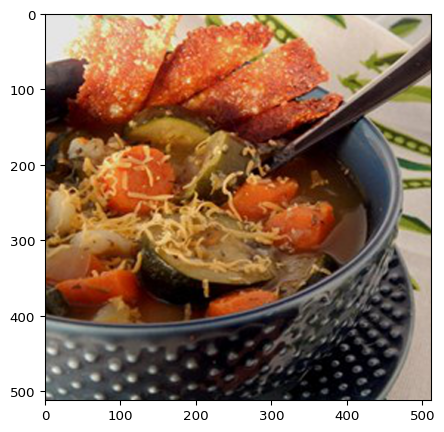

In [6]:
# Check data loading
for i, img in enumerate(ex_imgs):
    print("Image shape", img.shape)
    print("Ingr ids", ex_ingr_labels[i])
    print("Class id", ex_class_labels[i])
    print("# recipe steps", ex_nsteps[i])
    ia.imshow(img)
    break

In [22]:
# Callbacks and data augmentor
lr = .01
job_dir = './'

def data_aug(img):
    seq = iaa.Sequential([
        iaa.Cutout()
    ])
    img = seq(image=img)
    return img    

lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: lr + 0.02 * (0.5 ** (1 + epoch)),
    verbose=True)

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    os.path.join(job_dir, 'logs'),
    histogram_freq=1)

class MetricsHistory(Callback):
    def __init__(self):
        self.best_score = -1

    def on_epoch_end(self, epoch, logs={}):
        curr_score = logs['accuracy_ml']
        print('Epoch accuracy: ', curr_score)
        
        if curr_score > self.best_score:
            print("Better score, saving model ...")
            self.model.save('./logs/best_model-'+ datetime.now().strftime("%m-%d-%H") +'.h5')
            self.best_score = curr_score

metrics_cb = MetricsHistory()
# TODO: CSVLogger('logs/train_log.csv')

In [20]:
!rm -rf logs
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 17092), started 0:55:01 ago. (Use '!kill 17092' to kill it.)

In [21]:
# Train and evaluate
batch_size = 4
epochs = 10
datagen = ImageDataGenerator(preprocessing_function=data_aug) # Alt: prebatch images and cache, much faster performance
nn = model.create_keras_model(input_shape=(224,224,3), 
                                 learning_rate=.01)
history = nn.fit(
    datagen.flow(ex_imgs, ex_class_labels, batch_size=batch_size),
    steps_per_epoch=ex_imgs.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(ex_imgs, ex_class_labels),
    callbacks=[lr_decay_cb, tensorboard_cb, metrics_cb]
)

# Export model
export_path = os.path.join(job_dir, 'keras_export')
tf.keras.models.save_model(keras_model, export_path)
print('Model exported to: {}'.format(export_path))


Epoch 00001: LearningRateScheduler reducing learning rate to 0.02.
Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.6934 - accuracy_ml: 0.2917 WARNING:tensorflow:Model was constructed with shape (None, 224, 224, 3) for input Tensor("mobilenetv2_1.00_224_input_3:0", shape=(None, 224, 224, 3), dtype=float32), but it was called on an input with incompatible shape (None, 512, 512, 3).
Epoch accuracy:  0.2916666567325592
Better score, saving model ...
6/6 [==============================] - 5s 883ms/step - loss: 0.6934 - accuracy_ml: 0.2917 - val_loss: 0.6933 - val_accuracy_ml: 0.4583 - lr: 0.0200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.015.
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.6933 - accuracy_ml: 0.4583Epoch accuracy:  0.4583333432674408
Better score, saving model ...
6/6 [==============================] - 4s 738ms/step - loss: 0.6933 - accuracy_ml: 0.4583 - val_loss: 0.6933 - val_accuracy_ml: 0.4583 - lr: 0.0150

Ep

Image  23
True:  ['potato salad']
Predicted:  ['background', 'crock pot', 'cream cheese', 'fried chicken']


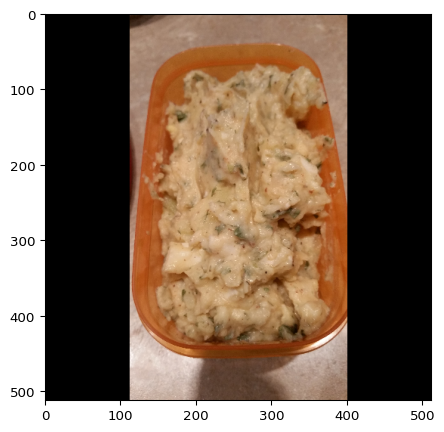

Image  12
True:  ['background']
Predicted:  ['background', 'crock pot']


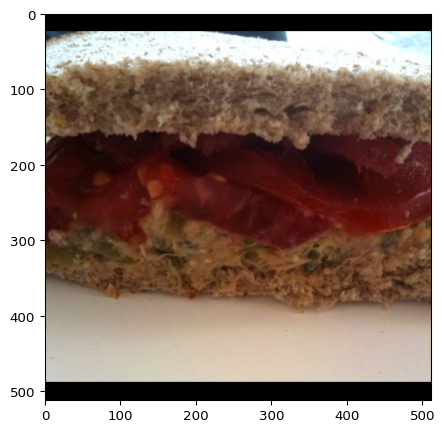

Image  9
True:  ['background']
Predicted:  ['background', 'crock pot', 'cream cheese', 'fried chicken']


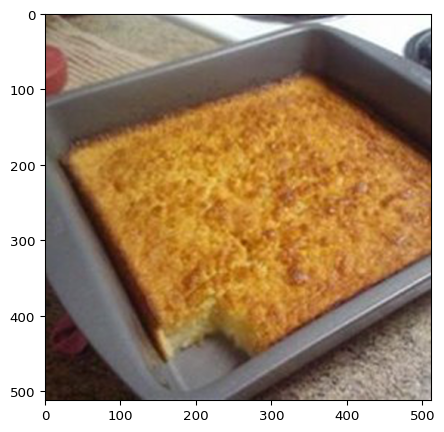

In [79]:
# Evaluate predictions
# TODO: downweight background loss, will badly skew class preds
sample = np.random.choice(range(len(ex_imgs)), 3, replace=False)
results = nn.predict(ex_imgs[sample])
for i, pred in zip(sample, results):    
    truth = ex_class_labels[i]
    img = ex_imgs[i]
    
    true_class_id = np.where(truth == 1)[0]
    pred_class_id = np.where(pred > 1e-9)[0]
    
    print("Image ", i)
    print("True: ", [id2class[x] for x in true_class_id])
    print("Predicted: ", [id2class[x] for x in pred_class_id])
    ia.imshow(img)